# Procurement KPI Analytics - Key Performance Indicators Analysis

**Objective**: Calculate, analyze, and visualize key procurement performance indicators to drive strategic decision-making.

**Key Analysis Areas**:
- Financial Performance KPIs (cost savings, spend analysis, ROI)
- Supplier Performance KPIs (delivery, quality, compliance)
- Operational Efficiency KPIs (lead times, order fulfillment)
- Quality and Risk KPIs (defect rates, compliance, risk scores)
- Category and Trend Analysis
- Executive Dashboard Creation

**Input**: Feature-engineered procurement dataset

**Output**: Comprehensive KPI analysis, dashboards, and strategic insights

---

## 1. Setup and Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import warnings
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Any
import calendar

# Configure display and warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings('ignore')

# Set plotting themes
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Custom color palette for consistency
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72', 
    'success': '#F18F01',
    'warning': '#C73E1D',
    'neutral': '#7209B7'
}

print("KPI Analysis environment initialized")
print(f"Analysis timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

KPI Analysis environment initialized
Analysis timestamp: 2025-07-09 07:56:03


In [2]:
# Load feature-engineered dataset
try:
    df = pd.read_csv('../data/processed/procurement_features_engineered.csv')
    print("Feature-engineered dataset loaded successfully")
    print(f"Dataset shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
except FileNotFoundError:
    print("Error: Feature-engineered dataset not found.")
    print("Expected file: '../data/processed/procurement_features_engineered.csv'")
    print("Please run the feature engineering notebook first.")

# Convert date columns
date_columns = ['Order_Date', 'Delivery_Date']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Data overview
print(f"\nData period: {df['Order_Date'].min().strftime('%Y-%m-%d')} to {df['Order_Date'].max().strftime('%Y-%m-%d')}")
print(f"Total procurement records: {len(df):,}")
print(f"Unique suppliers: {df['Supplier'].nunique():,}")
print(f"Unique categories: {df['Item_Category'].nunique():,}")
print(f"Total procurement value: ${df['total_negotiated_value'].sum():,.2f}")

Feature-engineered dataset loaded successfully
Dataset shape: 777 rows x 63 columns

Data period: 2022-01-01 to 2024-01-01
Total procurement records: 777
Unique suppliers: 5
Unique categories: 5
Total procurement value: $45,373,696.39


## 2. Financial Performance KPIs

In [3]:
# Calculate comprehensive financial KPIs
def calculate_financial_kpis(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Calculate key financial performance indicators.
    """
    print("Calculating Financial Performance KPIs:")
    print("=" * 50)
    
    kpis = {}
    
    # Total spend and savings
    kpis['total_procurement_spend'] = df['total_negotiated_value'].sum()
    kpis['total_original_spend'] = df['total_original_value'].sum()
    kpis['total_cost_savings'] = df['cost_savings'].sum()
    kpis['overall_savings_rate'] = (kpis['total_cost_savings'] / kpis['total_original_spend'] * 100)
    
    # Order metrics
    kpis['total_orders'] = len(df)
    kpis['average_order_value'] = df['total_negotiated_value'].mean()
    kpis['median_order_value'] = df['total_negotiated_value'].median()
    
    # Negotiation effectiveness
    successful_negotiations = (df['savings_percentage'] > 0).sum()
    kpis['negotiation_success_rate'] = (successful_negotiations / len(df) * 100)
    kpis['average_savings_per_order'] = df['cost_savings'].mean()
    
    # Monthly spending patterns
    monthly_spend = df.groupby(['order_year', 'order_month'])['total_negotiated_value'].sum()
    kpis['average_monthly_spend'] = monthly_spend.mean()
    kpis['monthly_spend_volatility'] = monthly_spend.std()
    
    # Cost efficiency metrics
    if 'cost_per_unit_negotiated' in df.columns:
        kpis['average_cost_per_unit'] = df['cost_per_unit_negotiated'].mean()
    
    # High-value order analysis
    if 'is_high_value_order' in df.columns:
        high_value_orders = df[df['is_high_value_order'] == True]
        kpis['high_value_order_count'] = len(high_value_orders)
        kpis['high_value_order_percentage'] = (len(high_value_orders) / len(df) * 100)
        kpis['high_value_order_savings_rate'] = high_value_orders['savings_percentage'].mean()
    
    return kpis

# Calculate financial KPIs
financial_kpis = calculate_financial_kpis(df)

# Display key financial metrics
print("KEY FINANCIAL PERFORMANCE INDICATORS:")
print("=" * 50)
print(f"Total Procurement Spend: ${financial_kpis['total_procurement_spend']:,.2f}")
print(f"Total Cost Savings: ${financial_kpis['total_cost_savings']:,.2f}")
print(f"Overall Savings Rate: {financial_kpis['overall_savings_rate']:.2f}%")
print(f"Negotiation Success Rate: {financial_kpis['negotiation_success_rate']:.1f}%")
print(f"Average Order Value: ${financial_kpis['average_order_value']:,.2f}")
print(f"Average Savings per Order: ${financial_kpis['average_savings_per_order']:,.2f}")
print(f"Average Monthly Spend: ${financial_kpis['average_monthly_spend']:,.2f}")

Calculating Financial Performance KPIs:
KEY FINANCIAL PERFORMANCE INDICATORS:
Total Procurement Spend: $45,373,696.39
Total Cost Savings: $3,931,126.47
Overall Savings Rate: 7.97%
Negotiation Success Rate: 100.0%
Average Order Value: $58,396.01
Average Savings per Order: $5,059.36
Average Monthly Spend: $1,814,947.86


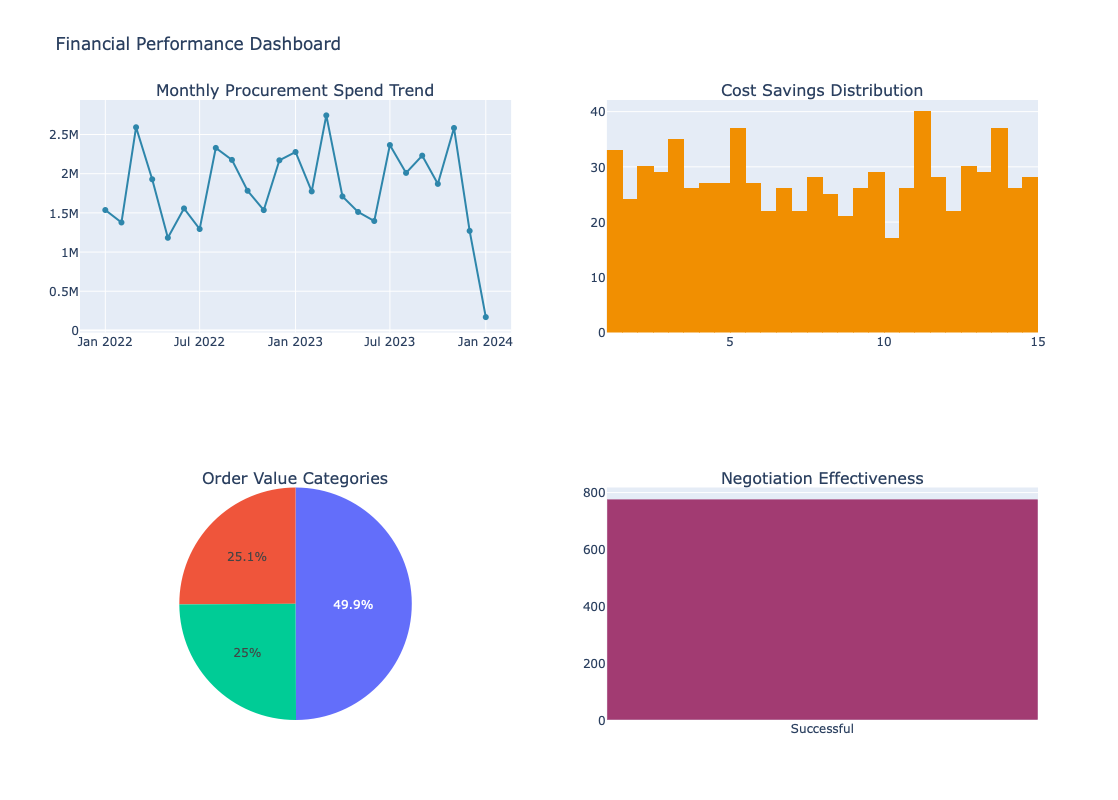

In [4]:
# Create financial performance visualizations
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Monthly Procurement Spend Trend',
        'Cost Savings Distribution',
        'Order Value Categories',
        'Negotiation Effectiveness'
    ),
    specs=[[{"type": "scatter"}, {"type": "histogram"}],
           [{"type": "pie"}, {"type": "bar"}]]
)

# 1. Monthly spend trend
monthly_data = df.groupby(['order_year', 'order_month']).agg({
    'total_negotiated_value': 'sum',
    'cost_savings': 'sum'
}).reset_index()
monthly_data['year_month'] = monthly_data['order_year'].astype(str) + '-' + monthly_data['order_month'].astype(str).str.zfill(2)

fig.add_trace(
    go.Scatter(
        x=monthly_data['year_month'],
        y=monthly_data['total_negotiated_value'],
        mode='lines+markers',
        name='Monthly Spend',
        line=dict(color=COLORS['primary'])
    ),
    row=1, col=1
)

# 2. Cost savings distribution
fig.add_trace(
    go.Histogram(
        x=df['savings_percentage'],
        nbinsx=30,
        name='Savings %',
        marker_color=COLORS['success']
    ),
    row=1, col=2
)

# 3. Order value categories
if 'order_size_category' in df.columns:
    size_counts = df['order_size_category'].value_counts()
    fig.add_trace(
        go.Pie(
            labels=size_counts.index,
            values=size_counts.values,
            name="Order Size"
        ),
        row=2, col=1
    )

# 4. Negotiation effectiveness
if 'negotiation_effectiveness' in df.columns:
    neg_counts = df['negotiation_effectiveness'].value_counts()
    fig.add_trace(
        go.Bar(
            x=neg_counts.index,
            y=neg_counts.values,
            name="Negotiation Results",
            marker_color=COLORS['secondary']
        ),
        row=2, col=2
    )

fig.update_layout(
    height=800,
    title_text="Financial Performance Dashboard",
    showlegend=False
)

fig.show()

## 3. Supplier Performance KPIs

In [5]:
# Calculate supplier performance KPIs
def calculate_supplier_kpis(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Calculate key supplier performance indicators.
    """
    print("Calculating Supplier Performance KPIs:")
    print("=" * 50)
    
    kpis = {}
    
    # Basic supplier metrics
    kpis['total_suppliers'] = df['Supplier'].nunique()
    kpis['average_orders_per_supplier'] = len(df) / kpis['total_suppliers']
    
    # Lead time performance
    kpis['average_lead_time'] = df['lead_time_days'].mean()
    kpis['median_lead_time'] = df['lead_time_days'].median()
    kpis['lead_time_std'] = df['lead_time_days'].std()
    
    # On-time delivery (assuming orders with lead time <= 14 days are on-time)
    on_time_orders = (df['lead_time_days'] <= 14).sum()
    kpis['on_time_delivery_rate'] = (on_time_orders / len(df) * 100)
    
    # Fast delivery rate
    if 'is_fast_delivery' in df.columns:
        kpis['fast_delivery_rate'] = (df['is_fast_delivery'].sum() / len(df) * 100)
    
    # Supplier tier distribution
    if 'supplier_tier' in df.columns:
        tier_distribution = df['supplier_tier'].value_counts(normalize=True) * 100
        kpis['excellent_suppliers_pct'] = tier_distribution.get('Excellent', 0)
        kpis['good_suppliers_pct'] = tier_distribution.get('Good', 0)
        kpis['poor_suppliers_pct'] = tier_distribution.get('Poor', 0)
    
    # Supplier concentration risk
    supplier_spend = df.groupby('Supplier')['total_negotiated_value'].sum().sort_values(ascending=False)
    total_spend = supplier_spend.sum()
    
    kpis['top_supplier_concentration'] = (supplier_spend.iloc[0] / total_spend * 100)
    kpis['top_5_supplier_concentration'] = (supplier_spend.head(5).sum() / total_spend * 100)
    
    # Supplier performance scores
    if 'supplier_overall_score' in df.columns:
        supplier_scores = df.groupby('Supplier')['supplier_overall_score'].first()
        kpis['average_supplier_score'] = supplier_scores.mean()
        kpis['supplier_score_std'] = supplier_scores.std()
    
    return kpis

# Calculate supplier KPIs
supplier_kpis = calculate_supplier_kpis(df)

# Display key supplier metrics
print("KEY SUPPLIER PERFORMANCE INDICATORS:")
print("=" * 50)
print(f"Total Active Suppliers: {supplier_kpis['total_suppliers']}")
print(f"Average Lead Time: {supplier_kpis['average_lead_time']:.1f} days")
print(f"On-Time Delivery Rate: {supplier_kpis['on_time_delivery_rate']:.1f}%")
print(f"Top Supplier Concentration: {supplier_kpis['top_supplier_concentration']:.1f}%")
print(f"Top 5 Suppliers Concentration: {supplier_kpis['top_5_supplier_concentration']:.1f}%")

if 'average_supplier_score' in supplier_kpis:
    print(f"Average Supplier Score: {supplier_kpis['average_supplier_score']:.1f}/100")

if 'fast_delivery_rate' in supplier_kpis:
    print(f"Fast Delivery Rate (≤7 days): {supplier_kpis['fast_delivery_rate']:.1f}%")

Calculating Supplier Performance KPIs:
KEY SUPPLIER PERFORMANCE INDICATORS:
Total Active Suppliers: 5
Average Lead Time: 10.8 days
On-Time Delivery Rate: 60.7%
Top Supplier Concentration: 21.7%
Top 5 Suppliers Concentration: 100.0%
Average Supplier Score: 51.4/100
Fast Delivery Rate (≤7 days): 29.5%


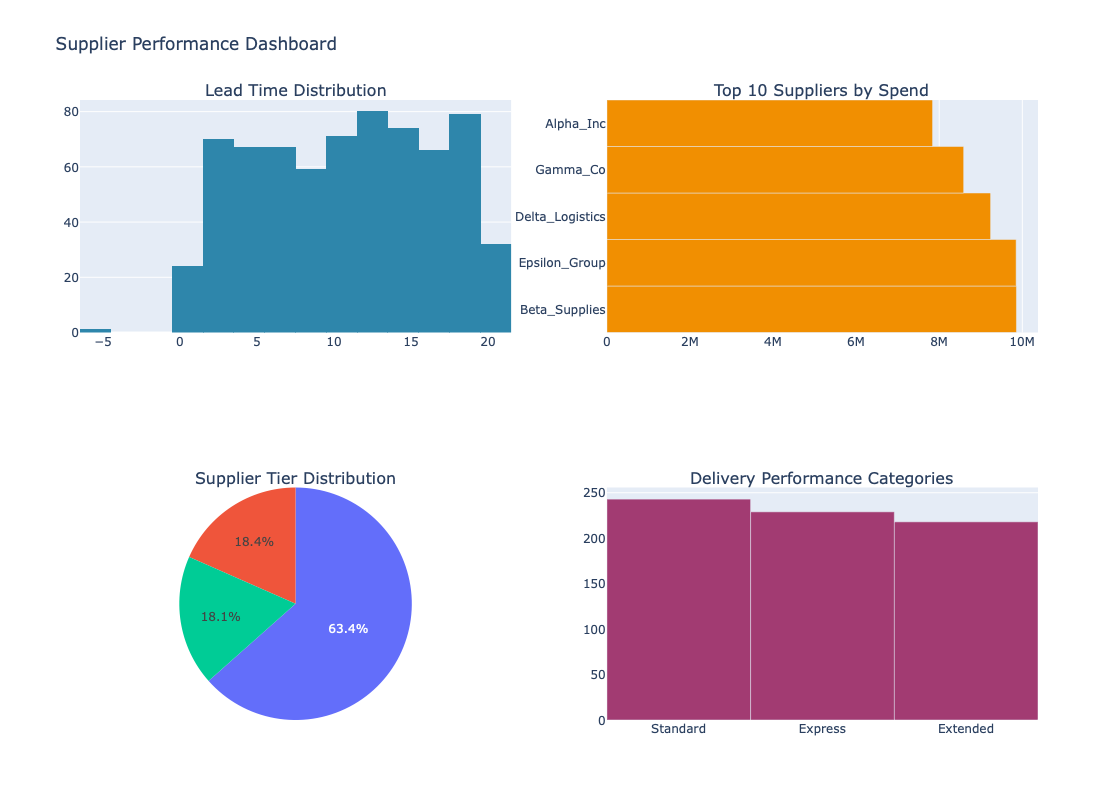

In [6]:
# Create supplier performance dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Lead Time Distribution',
        'Top 10 Suppliers by Spend',
        'Supplier Tier Distribution',
        'Delivery Performance Categories'
    ),
    specs=[[{"type": "histogram"}, {"type": "bar"}],
           [{"type": "pie"}, {"type": "bar"}]]
)

# 1. Lead time distribution
fig.add_trace(
    go.Histogram(
        x=df['lead_time_days'],
        nbinsx=25,
        name='Lead Time',
        marker_color=COLORS['primary']
    ),
    row=1, col=1
)

# 2. Top suppliers by spend
top_suppliers = df.groupby('Supplier')['total_negotiated_value'].sum().nlargest(10)
fig.add_trace(
    go.Bar(
        x=top_suppliers.values,
        y=top_suppliers.index,
        orientation='h',
        name='Spend',
        marker_color=COLORS['success']
    ),
    row=1, col=2
)

# 3. Supplier tier distribution
if 'supplier_tier' in df.columns:
    tier_counts = df['supplier_tier'].value_counts()
    fig.add_trace(
        go.Pie(
            labels=tier_counts.index,
            values=tier_counts.values,
            name="Supplier Tiers"
        ),
        row=2, col=1
    )

# 4. Delivery performance categories
if 'lead_time_category' in df.columns:
    delivery_counts = df['lead_time_category'].value_counts()
    fig.add_trace(
        go.Bar(
            x=delivery_counts.index,
            y=delivery_counts.values,
            name="Delivery Categories",
            marker_color=COLORS['secondary']
        ),
        row=2, col=2
    )

fig.update_layout(
    height=800,
    title_text="Supplier Performance Dashboard",
    showlegend=False
)

fig.show()

## 4. Quality and Compliance KPIs

In [7]:
# Calculate quality and compliance KPIs
def calculate_quality_kpis(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Calculate key quality and compliance indicators.
    """
    print("Calculating Quality and Compliance KPIs:")
    print("=" * 50)
    
    kpis = {}
    
    # Quality metrics
    kpis['overall_defect_rate'] = df['defect_rate'].mean()
    kpis['median_defect_rate'] = df['defect_rate'].median()
    kpis['defect_rate_std'] = df['defect_rate'].std()
    
    # Perfect orders
    if 'is_perfect_order' in df.columns:
        perfect_orders = df['is_perfect_order'].sum()
        kpis['perfect_order_rate'] = (perfect_orders / len(df) * 100)
    
    # Quality severity distribution
    if 'defect_severity' in df.columns:
        severity_dist = df['defect_severity'].value_counts(normalize=True) * 100
        kpis['excellent_quality_pct'] = severity_dist.get('Excellent', 0)
        kpis['critical_quality_pct'] = severity_dist.get('Critical', 0)
    
    # Compliance metrics
    if 'Compliance' in df.columns:
        compliant_orders = (df['Compliance'] == 'Compliant').sum()
        kpis['compliance_rate'] = (compliant_orders / len(df) * 100)
        
        non_compliant_orders = (df['Compliance'] == 'Non-Compliant').sum()
        kpis['non_compliance_rate'] = (non_compliant_orders / len(df) * 100)
    
    # Cost of quality (defective units cost impact)
    total_defective_units = df['Defective_Units'].sum()
    total_units = df['Quantity'].sum()
    kpis['total_defective_units'] = total_defective_units
    kpis['defective_units_rate'] = (total_defective_units / total_units * 100)
    
    # Quality cost impact
    if 'defect_cost_impact' in df.columns:
        kpis['total_quality_cost_impact'] = df['defect_cost_impact'].sum()
        kpis['quality_cost_percentage'] = (kpis['total_quality_cost_impact'] / df['total_negotiated_value'].sum() * 100)
    
    return kpis

# Calculate quality KPIs
quality_kpis = calculate_quality_kpis(df)

# Display key quality metrics
print("KEY QUALITY AND COMPLIANCE INDICATORS:")
print("=" * 50)
print(f"Overall Defect Rate: {quality_kpis['overall_defect_rate']:.2f}%")
print(f"Defective Units Rate: {quality_kpis['defective_units_rate']:.2f}%")

if 'perfect_order_rate' in quality_kpis:
    print(f"Perfect Order Rate: {quality_kpis['perfect_order_rate']:.1f}%")

if 'compliance_rate' in quality_kpis:
    print(f"Compliance Rate: {quality_kpis['compliance_rate']:.1f}%")
    print(f"Non-Compliance Rate: {quality_kpis['non_compliance_rate']:.1f}%")

if 'total_quality_cost_impact' in quality_kpis:
    print(f"Total Quality Cost Impact: ${quality_kpis['total_quality_cost_impact']:,.2f}")
    print(f"Quality Cost as % of Spend: {quality_kpis['quality_cost_percentage']:.2f}%")

print(f"Total Defective Units: {quality_kpis['total_defective_units']:,.0f}")

Calculating Quality and Compliance KPIs:
KEY QUALITY AND COMPLIANCE INDICATORS:
Overall Defect Rate: 5.78%
Defective Units Rate: 5.64%
Perfect Order Rate: 18.0%
Compliance Rate: 0.0%
Non-Compliance Rate: 0.0%
Total Defective Units: 47,949


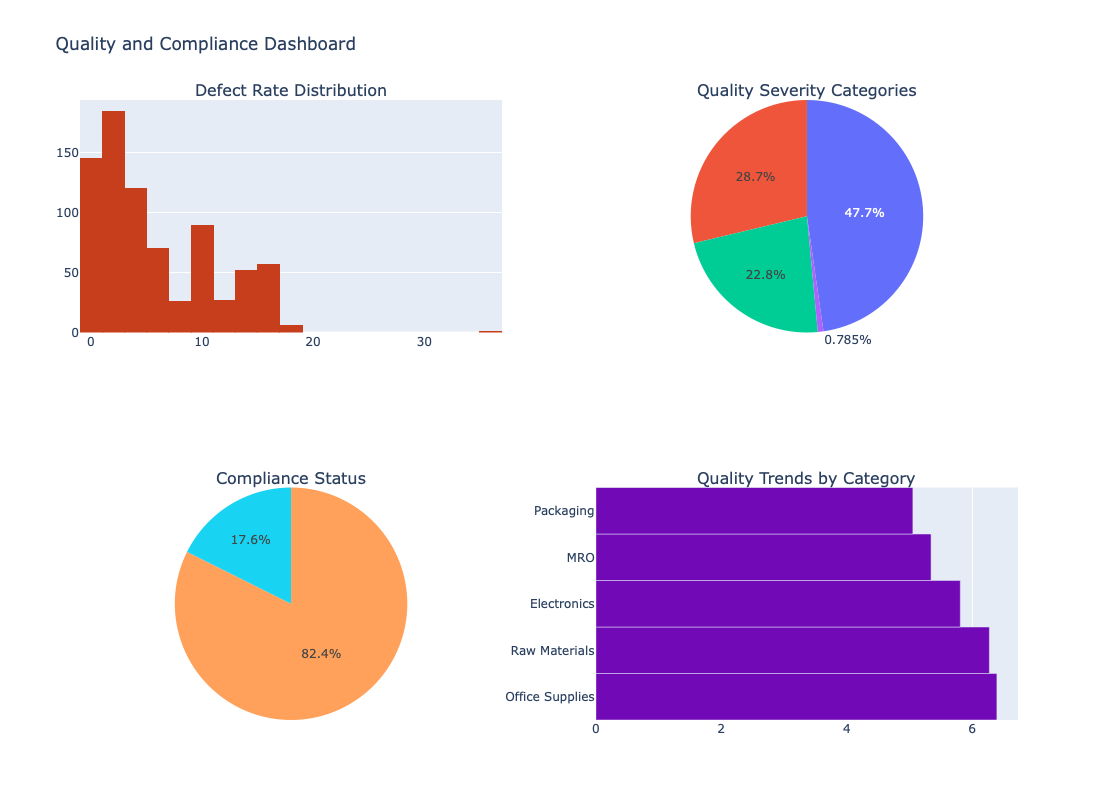

In [8]:
# Create quality and compliance dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Defect Rate Distribution',
        'Quality Severity Categories',
        'Compliance Status',
        'Quality Trends by Category'
    ),
    specs=[[{"type": "histogram"}, {"type": "pie"}],
           [{"type": "pie"}, {"type": "bar"}]]
)

# 1. Defect rate distribution
fig.add_trace(
    go.Histogram(
        x=df['defect_rate'],
        nbinsx=20,
        name='Defect Rate',
        marker_color=COLORS['warning']
    ),
    row=1, col=1
)

# 2. Quality severity categories
if 'defect_severity' in df.columns:
    severity_counts = df['defect_severity'].value_counts()
    fig.add_trace(
        go.Pie(
            labels=severity_counts.index,
            values=severity_counts.values,
            name="Quality Severity"
        ),
        row=1, col=2
    )

# 3. Compliance status
if 'Compliance' in df.columns:
    compliance_counts = df['Compliance'].value_counts()
    fig.add_trace(
        go.Pie(
            labels=compliance_counts.index,
            values=compliance_counts.values,
            name="Compliance Status"
        ),
        row=2, col=1
    )

# 4. Average defect rate by category
category_quality = df.groupby('Item_Category')['defect_rate'].mean().sort_values(ascending=False).head(10)
fig.add_trace(
    go.Bar(
        x=category_quality.values,
        y=category_quality.index,
        orientation='h',
        name="Defect Rate by Category",
        marker_color=COLORS['neutral']
    ),
    row=2, col=2
)

fig.update_layout(
    height=800,
    title_text="Quality and Compliance Dashboard",
    showlegend=False
)

fig.show()

## 5. Risk Assessment KPIs

In [9]:
# Calculate risk assessment KPIs
def calculate_risk_kpis(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Calculate key risk assessment indicators.
    """
    print("Calculating Risk Assessment KPIs:")
    print("=" * 50)
    
    kpis = {}
    
    # Overall risk distribution
    if 'composite_risk_score' in df.columns:
        kpis['average_risk_score'] = df['composite_risk_score'].mean()
        kpis['high_risk_orders_count'] = (df['composite_risk_score'] >= 2).sum()
        kpis['high_risk_orders_pct'] = (kpis['high_risk_orders_count'] / len(df) * 100)
    
    # Risk level distribution
    if 'risk_level' in df.columns:
        risk_dist = df['risk_level'].value_counts(normalize=True) * 100
        kpis['low_risk_pct'] = risk_dist.get('Low', 0)
        kpis['critical_risk_pct'] = risk_dist.get('Critical', 0)
    
    # Specific risk categories
    risk_categories = ['delivery_risk', 'quality_risk', 'compliance_risk']
    for risk_cat in risk_categories:
        if risk_cat in df.columns:
            risk_count = df[risk_cat].sum()
            kpis[f'{risk_cat}_count'] = risk_count
            kpis[f'{risk_cat}_pct'] = (risk_count / len(df) * 100)
    
    # Supplier dependency risk
    supplier_spend = df.groupby('Supplier')['total_negotiated_value'].sum()
    total_spend = supplier_spend.sum()
    suppliers_over_20pct = (supplier_spend / total_spend > 0.20).sum()
    kpis['high_dependency_suppliers'] = suppliers_over_20pct
    
    # Category concentration risk
    category_spend = df.groupby('Item_Category')['total_negotiated_value'].sum()
    top_category_concentration = (category_spend.max() / total_spend * 100)
    kpis['top_category_concentration'] = top_category_concentration
    
    # Financial risk (high-value orders with issues)
    if 'is_high_value_order' in df.columns and 'composite_risk_score' in df.columns:
        high_value_high_risk = ((df['is_high_value_order'] == True) & 
                               (df['composite_risk_score'] >= 2)).sum()
        kpis['high_value_high_risk_orders'] = high_value_high_risk
    
    return kpis

# Calculate risk KPIs
risk_kpis = calculate_risk_kpis(df)

# Display key risk metrics
print("KEY RISK ASSESSMENT INDICATORS:")
print("=" * 50)

if 'average_risk_score' in risk_kpis:
    print(f"Average Risk Score: {risk_kpis['average_risk_score']:.2f}")
    print(f"High Risk Orders: {risk_kpis['high_risk_orders_count']} ({risk_kpis['high_risk_orders_pct']:.1f}%)")

# Display individual risk categories
risk_categories = ['delivery_risk', 'quality_risk', 'compliance_risk']
for risk_cat in risk_categories:
    if f'{risk_cat}_pct' in risk_kpis:
        print(f"{risk_cat.replace('_', ' ').title()}: {risk_kpis[f'{risk_cat}_pct']:.1f}%")

print(f"High Dependency Suppliers (>20% spend): {risk_kpis['high_dependency_suppliers']}")
print(f"Top Category Concentration: {risk_kpis['top_category_concentration']:.1f}%")

if 'high_value_high_risk_orders' in risk_kpis:
    print(f"High-Value High-Risk Orders: {risk_kpis['high_value_high_risk_orders']}")

Calculating Risk Assessment KPIs:
KEY RISK ASSESSMENT INDICATORS:
Average Risk Score: 0.46
High Risk Orders: 18 (2.3%)
Delivery Risk: 4.1%
Quality Risk: 42.2%
Compliance Risk: 0.0%
High Dependency Suppliers (>20% spend): 3
Top Category Concentration: 22.3%
High-Value High-Risk Orders: 1


## 6. Category and Trend Analysis

In [10]:
# Comprehensive category analysis
def analyze_category_performance(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze performance by item category.
    """
    print("Analyzing Category Performance:")
    print("=" * 50)
    
    category_analysis = df.groupby('Item_Category').agg({
        'PO_ID': 'count',
        'total_negotiated_value': ['sum', 'mean'],
        'cost_savings': ['sum', 'mean'],
        'savings_percentage': 'mean',
        'lead_time_days': 'mean',
        'defect_rate': 'mean',
        'Supplier': 'nunique'
    }).round(2)
    
    # Flatten column names
    category_analysis.columns = ['_'.join(col).strip() if col[1] else col[0] for col in category_analysis.columns]
    
    # Rename columns for clarity
    column_mapping = {
        'PO_ID_count': 'Total_Orders',
        'total_negotiated_value_sum': 'Total_Spend',
        'total_negotiated_value_mean': 'Avg_Order_Value',
        'cost_savings_sum': 'Total_Savings',
        'cost_savings_mean': 'Avg_Savings_Per_Order',
        'savings_percentage_mean': 'Avg_Savings_Rate',
        'lead_time_days_mean': 'Avg_Lead_Time',
        'defect_rate_mean': 'Avg_Defect_Rate',
        'Supplier_nunique': 'Supplier_Count'
    }
    
    category_analysis = category_analysis.rename(columns=column_mapping)
    
    # Calculate spend share
    total_spend = category_analysis['Total_Spend'].sum()
    category_analysis['Spend_Share_Pct'] = (category_analysis['Total_Spend'] / total_spend * 100).round(2)
    
    # Sort by total spend
    category_analysis = category_analysis.sort_values('Total_Spend', ascending=False)
    
    return category_analysis

# Perform category analysis
category_performance = analyze_category_performance(df)

print("TOP 10 CATEGORIES BY SPEND:")
print("=" * 50)
display(category_performance.head(10))

# Identify best and worst performing categories
print("\nCATEGORY PERFORMANCE INSIGHTS:")
print("=" * 50)

# Best savings rate
best_savings = category_performance.nlargest(3, 'Avg_Savings_Rate')
print("Top 3 Categories by Savings Rate:")
for idx, row in best_savings.iterrows():
    print(f"  {idx}: {row['Avg_Savings_Rate']:.2f}% (${row['Total_Savings']:,.0f} total)")

# Fastest delivery
fastest_delivery = category_performance.nsmallest(3, 'Avg_Lead_Time')
print("\nTop 3 Categories by Lead Time:")
for idx, row in fastest_delivery.iterrows():
    print(f"  {idx}: {row['Avg_Lead_Time']:.1f} days")

# Best quality
best_quality = category_performance.nsmallest(3, 'Avg_Defect_Rate')
print("\nTop 3 Categories by Quality (Lowest Defect Rate):")
for idx, row in best_quality.iterrows():
    print(f"  {idx}: {row['Avg_Defect_Rate']:.2f}% defect rate")

Analyzing Category Performance:
TOP 10 CATEGORIES BY SPEND:


,Total_Orders,Total_Spend,Avg_Order_Value,Total_Savings,Avg_Savings_Per_Order,Avg_Savings_Rate,Avg_Lead_Time,Avg_Defect_Rate,Supplier_Count,Spend_Share_Pct
Item_Category,,,,,,,,,,
MRO,164,10126608.86,61747.62,902312.31,5501.90,8.21,11.60,5.34,5,22.32
Office Supplies,174,10007583.03,57514.84,844096.16,4851.13,7.66,10.41,6.39,5,22.06
Electronics,152,8642550.60,56858.89,742876.23,4887.34,7.72,11.02,5.81,5,19.05
Raw Materials,139,8471241.42,60944.18,709097.25,5101.42,7.84,10.34,6.27,5,18.67
Packaging,148,8125712.48,54903.46,732744.52,4950.98,8.44,10.41,5.05,5,17.91



CATEGORY PERFORMANCE INSIGHTS:
Top 3 Categories by Savings Rate:
  Packaging: 8.44% ($732,745 total)
  MRO: 8.21% ($902,312 total)
  Raw Materials: 7.84% ($709,097 total)

Top 3 Categories by Lead Time:
  Raw Materials: 10.3 days
  Office Supplies: 10.4 days
  Packaging: 10.4 days

Top 3 Categories by Quality (Lowest Defect Rate):
  Packaging: 5.05% defect rate
  MRO: 5.34% defect rate
  Electronics: 5.81% defect rate


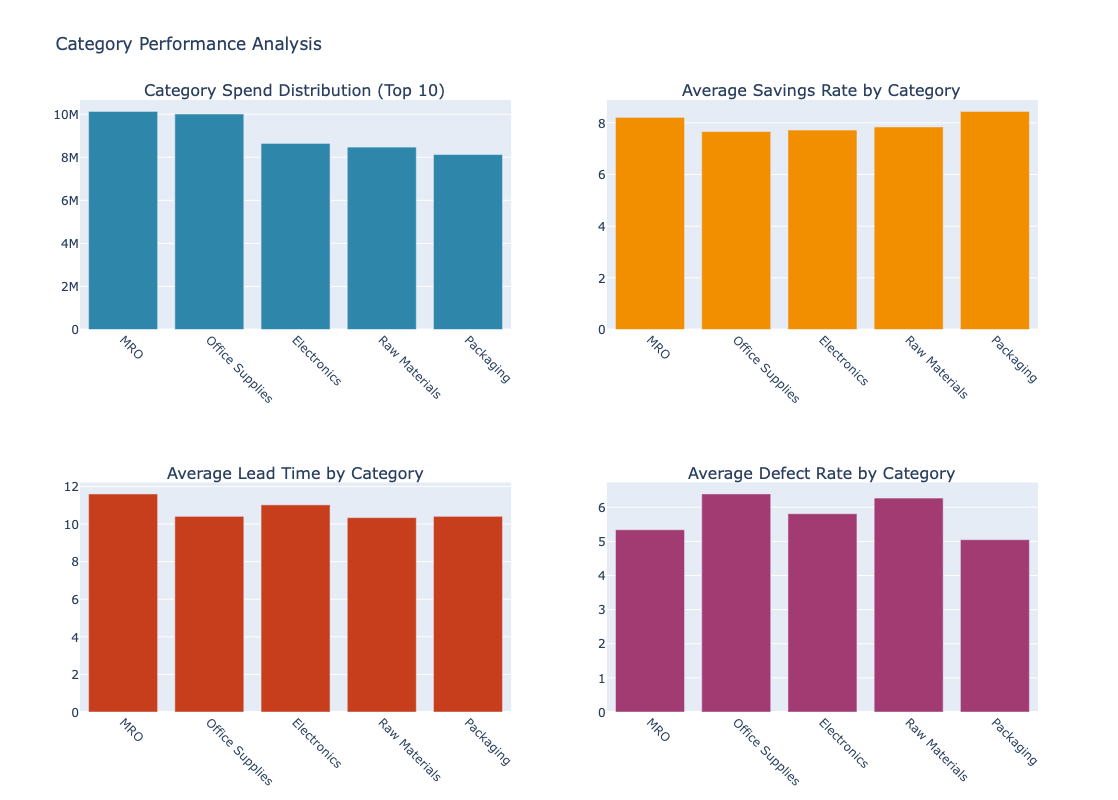

In [11]:
# Create category performance visualization
top_10_categories = category_performance.head(10)

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Category Spend Distribution (Top 10)',
        'Average Savings Rate by Category',
        'Average Lead Time by Category',
        'Average Defect Rate by Category'
    ),
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "bar"}]]
)

# 1. Category spend distribution
fig.add_trace(
    go.Bar(
        x=top_10_categories.index,
        y=top_10_categories['Total_Spend'],
        name='Total Spend',
        marker_color=COLORS['primary']
    ),
    row=1, col=1
)

# 2. Savings rate by category
fig.add_trace(
    go.Bar(
        x=top_10_categories.index,
        y=top_10_categories['Avg_Savings_Rate'],
        name='Avg Savings Rate',
        marker_color=COLORS['success']
    ),
    row=1, col=2
)

# 3. Lead time by category
fig.add_trace(
    go.Bar(
        x=top_10_categories.index,
        y=top_10_categories['Avg_Lead_Time'],
        name='Avg Lead Time',
        marker_color=COLORS['warning']
    ),
    row=2, col=1
)

# 4. Defect rate by category
fig.add_trace(
    go.Bar(
        x=top_10_categories.index,
        y=top_10_categories['Avg_Defect_Rate'],
        name='Avg Defect Rate',
        marker_color=COLORS['secondary']
    ),
    row=2, col=2
)

# Update x-axis labels to be rotated
fig.update_xaxes(tickangle=45)

fig.update_layout(
    height=800,
    title_text="Category Performance Analysis",
    showlegend=False
)

fig.show()

## 7. Executive KPI Summary

In [13]:
# Create comprehensive executive KPI summary
def create_executive_summary(financial_kpis, supplier_kpis, quality_kpis, risk_kpis, df) -> Dict[str, Any]:
    """
    Create executive-level KPI summary.
    """
    print("Creating Executive KPI Summary:")
    print("=" * 50)
    
    summary = {
        'analysis_date': datetime.now().strftime('%Y-%m-%d'),
        'data_period': f"{df['Order_Date'].min().strftime('%Y-%m-%d')} to {df['Order_Date'].max().strftime('%Y-%m-%d')}",
        'total_records': len(df)
    }
    
    # Financial performance
    summary['financial'] = {
        'total_spend': financial_kpis['total_procurement_spend'],
        'total_savings': financial_kpis['total_cost_savings'],
        'savings_rate': financial_kpis['overall_savings_rate'],
        'negotiation_success_rate': financial_kpis['negotiation_success_rate'],
        'avg_order_value': financial_kpis['average_order_value']
    }
    
    # Supplier performance
    summary['supplier'] = {
        'total_suppliers': supplier_kpis['total_suppliers'],
        'avg_lead_time': supplier_kpis['average_lead_time'],
        'on_time_delivery_rate': supplier_kpis['on_time_delivery_rate'],
        'top_supplier_concentration': supplier_kpis['top_supplier_concentration']
    }
    
    # Quality performance
    summary['quality'] = {
        'overall_defect_rate': quality_kpis['overall_defect_rate'],
        'defective_units_rate': quality_kpis['defective_units_rate']
    }
    
    if 'compliance_rate' in quality_kpis:
        summary['quality']['compliance_rate'] = quality_kpis['compliance_rate']
    
    if 'perfect_order_rate' in quality_kpis:
        summary['quality']['perfect_order_rate'] = quality_kpis['perfect_order_rate']
    
    # Risk assessment
    summary['risk'] = {
        'high_dependency_suppliers': risk_kpis['high_dependency_suppliers'],
        'top_category_concentration': risk_kpis['top_category_concentration']
    }
    
    if 'high_risk_orders_pct' in risk_kpis:
        summary['risk']['high_risk_orders_pct'] = risk_kpis['high_risk_orders_pct']
    
    return summary

# Create executive summary
executive_summary = create_executive_summary(financial_kpis, supplier_kpis, quality_kpis, risk_kpis, df)

# Display executive summary
print("EXECUTIVE PROCUREMENT KPI DASHBOARD")
print("=" * 60)
print(f"Analysis Date: {executive_summary['analysis_date']}")
print(f"Data Period: {executive_summary['data_period']}")
print(f"Total Records Analyzed: {executive_summary['total_records']:,}")

print("\n💰 FINANCIAL PERFORMANCE:")
print(f"  Total Procurement Spend: ${executive_summary['financial']['total_spend']:,.2f}")
print(f"  Total Cost Savings: ${executive_summary['financial']['total_savings']:,.2f}")
print(f"  Overall Savings Rate: {executive_summary['financial']['savings_rate']:.2f}%")
print(f"  Negotiation Success Rate: {executive_summary['financial']['negotiation_success_rate']:.1f}%")
print(f"  Average Order Value: ${executive_summary['financial']['avg_order_value']:,.2f}")

print("\n🏭 SUPPLIER PERFORMANCE:")
print(f"  Active Suppliers: {executive_summary['supplier']['total_suppliers']}")
print(f"  Average Lead Time: {executive_summary['supplier']['avg_lead_time']:.1f} days")
print(f"  On-Time Delivery Rate: {executive_summary['supplier']['on_time_delivery_rate']:.1f}%")
print(f"  Top Supplier Concentration: {executive_summary['supplier']['top_supplier_concentration']:.1f}%")

print("\n🎯 QUALITY PERFORMANCE:")
print(f"  Overall Defect Rate: {executive_summary['quality']['overall_defect_rate']:.2f}%")
print(f"  Defective Units Rate: {executive_summary['quality']['defective_units_rate']:.2f}%")
if 'compliance_rate' in executive_summary['quality']:
    print(f"  Compliance Rate: {executive_summary['quality']['compliance_rate']:.1f}%")
if 'perfect_order_rate' in executive_summary['quality']:
    print(f"  Perfect Order Rate: {executive_summary['quality']['perfect_order_rate']:.1f}%")

print("\n⚠️ RISK ASSESSMENT:")
print(f"  High Dependency Suppliers: {executive_summary['risk']['high_dependency_suppliers']}")
print(f"  Top Category Concentration: {executive_summary['risk']['top_category_concentration']:.1f}%")
if 'high_risk_orders_pct' in executive_summary['risk']:
    print(f"  High Risk Orders: {executive_summary['risk']['high_risk_orders_pct']:.1f}%")

Creating Executive KPI Summary:
EXECUTIVE PROCUREMENT KPI DASHBOARD
Analysis Date: 2025-07-09
Data Period: 2022-01-01 to 2024-01-01
Total Records Analyzed: 777

💰 FINANCIAL PERFORMANCE:
  Total Procurement Spend: $45,373,696.39
  Total Cost Savings: $3,931,126.47
  Overall Savings Rate: 7.97%
  Negotiation Success Rate: 100.0%
  Average Order Value: $58,396.01

🏭 SUPPLIER PERFORMANCE:
  Active Suppliers: 5
  Average Lead Time: 10.8 days
  On-Time Delivery Rate: 60.7%
  Top Supplier Concentration: 21.7%

🎯 QUALITY PERFORMANCE:
  Overall Defect Rate: 5.78%
  Defective Units Rate: 5.64%
  Compliance Rate: 0.0%
  Perfect Order Rate: 18.0%

⚠️ RISK ASSESSMENT:
  High Dependency Suppliers: 3
  Top Category Concentration: 22.3%
  High Risk Orders: 2.3%


## 8. Strategic Insights and Recommendations

In [15]:
# Generate strategic insights and recommendations
def generate_strategic_insights(executive_summary, category_performance, df) -> List[str]:
    """
    Generate strategic insights and actionable recommendations.
    """
    insights = []
    recommendations = []
    
    print("Generating Strategic Insights:")
    print("=" * 50)
    
    # Financial insights
    savings_rate = executive_summary['financial']['savings_rate']
    if savings_rate >= 10:
        insights.append(f"EXCELLENT negotiation performance with {savings_rate:.1f}% overall savings rate")
    elif savings_rate >= 5:
        insights.append(f"GOOD negotiation performance with {savings_rate:.1f}% overall savings rate")
        recommendations.append("Explore advanced negotiation training to improve savings rate above 10%")
    else:
        insights.append(f"IMPROVEMENT NEEDED: Low savings rate of {savings_rate:.1f}%")
        recommendations.append("URGENT: Implement strategic sourcing initiatives to improve negotiation outcomes")
    
    # Supplier dependency insights
    top_supplier_conc = executive_summary['supplier']['top_supplier_concentration']
    if top_supplier_conc > 30:
        insights.append(f"HIGH RISK: Single supplier accounts for {top_supplier_conc:.1f}% of spend")
        recommendations.append("Develop alternative suppliers to reduce dependency risk")
    elif top_supplier_conc > 20:
        insights.append(f"MODERATE RISK: Top supplier concentration at {top_supplier_conc:.1f}%")
        recommendations.append("Monitor supplier dependency and develop backup options")
    
    # Quality insights
    defect_rate = executive_summary['quality']['overall_defect_rate']
    if defect_rate < 2:
        insights.append(f"EXCELLENT quality performance with {defect_rate:.2f}% defect rate")
    elif defect_rate < 5:
        insights.append(f"ACCEPTABLE quality performance with {defect_rate:.2f}% defect rate")
        recommendations.append("Implement quality improvement programs to achieve <2% defect rate")
    else:
        insights.append(f"QUALITY CONCERN: High defect rate of {defect_rate:.2f}%")
        recommendations.append("URGENT: Launch comprehensive quality improvement initiative")
    
    # Lead time insights
    avg_lead_time = executive_summary['supplier']['avg_lead_time']
    if avg_lead_time <= 10:
        insights.append(f"EXCELLENT delivery performance with {avg_lead_time:.1f} day average lead time")
    elif avg_lead_time <= 20:
        insights.append(f"GOOD delivery performance with {avg_lead_time:.1f} day average lead time")
    else:
        insights.append(f"IMPROVEMENT NEEDED: Long lead time of {avg_lead_time:.1f} days")
        recommendations.append("Work with suppliers to reduce lead times and improve delivery performance")
    
    # Category insights
    top_category = category_performance.index[0]
    top_category_spend_pct = category_performance.iloc[0]['Spend_Share_Pct']
    
    if top_category_spend_pct > 40:
        insights.append(f"HIGH CONCENTRATION: {top_category} represents {top_category_spend_pct:.1f}% of total spend")
        recommendations.append(f"Diversify spending across categories to reduce {top_category} dependency")
    
    # Best performing categories
    best_savings_category = category_performance.nlargest(1, 'Avg_Savings_Rate').index[0]
    best_savings_rate = category_performance.loc[best_savings_category, 'Avg_Savings_Rate']
    insights.append(f"BEST PERFORMER: {best_savings_category} achieves {best_savings_rate:.1f}% savings rate")
    
    return insights, recommendations

# Generate insights and recommendations
strategic_insights, strategic_recommendations = generate_strategic_insights(executive_summary, category_performance, df)

# Display strategic insights
print("STRATEGIC INSIGHTS:")
print("=" * 50)
for i, insight in enumerate(strategic_insights, 1):
    print(f"{i:2d}. {insight}")

print("\nSTRATEGIC RECOMMENDATIONS:")
print("=" * 50)
for i, recommendation in enumerate(strategic_recommendations, 1):
    print(f"{i:2d}. {recommendation}")

# Additional opportunity analysis
print("\nOPPORTUNITY ANALYSIS:")
print("=" * 50)

# Calculate potential savings opportunity
current_savings = executive_summary['financial']['total_savings']
total_spend = executive_summary['financial']['total_spend']

# Assuming 10% is target savings rate
target_savings_rate = 10.0
potential_savings = (total_spend / (1 - target_savings_rate/100)) * (target_savings_rate/100) - current_savings

if potential_savings > 0:
    print(f"Potential Additional Savings: ${potential_savings:,.2f}")
    print(f"Target Savings Rate: {target_savings_rate}%")
    print(f"Current vs Target Gap: {target_savings_rate - executive_summary['financial']['savings_rate']:.1f} percentage points")

# Identify underperforming categories
below_avg_categories = category_performance[category_performance['Avg_Savings_Rate'] < executive_summary['financial']['savings_rate']]
if len(below_avg_categories) > 0:
    print(f"\nCategories Below Average Savings Rate: {len(below_avg_categories)}")
    print("Top 3 Improvement Opportunities:")
    for idx, row in below_avg_categories.head(3).iterrows():
        gap = executive_summary['financial']['savings_rate'] - row['Avg_Savings_Rate']
        potential = row['Total_Spend'] * (gap / 100)
        print(f"  {idx}: {gap:.1f}pp gap, ${potential:,.0f} potential savings")

Generating Strategic Insights:
STRATEGIC INSIGHTS:
 1. GOOD negotiation performance with 8.0% overall savings rate
 2. MODERATE RISK: Top supplier concentration at 21.7%
 3. QUALITY CONCERN: High defect rate of 5.78%
 4. GOOD delivery performance with 10.8 day average lead time
 5. BEST PERFORMER: Packaging achieves 8.4% savings rate

STRATEGIC RECOMMENDATIONS:
 1. Explore advanced negotiation training to improve savings rate above 10%
 2. Monitor supplier dependency and develop backup options
 3. URGENT: Launch comprehensive quality improvement initiative

OPPORTUNITY ANALYSIS:
Potential Additional Savings: $1,110,395.35
Target Savings Rate: 10.0%
Current vs Target Gap: 2.0 percentage points

Categories Below Average Savings Rate: 3
Top 3 Improvement Opportunities:
  Office Supplies: 0.3pp gap, $31,334 potential savings
  Electronics: 0.3pp gap, $21,875 potential savings
  Raw Materials: 0.1pp gap, $11,276 potential savings


## 9. Export KPI Results and Reports

In [16]:
# Export comprehensive KPI analysis results
import os
import json

# Ensure output directories exist
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../reports', exist_ok=True)

print("Exporting KPI Analysis Results:")
print("=" * 50)

# 1. Export category performance analysis
category_output_path = '../data/processed/category_performance_analysis.csv'
category_performance.to_csv(category_output_path)
print(f"Category analysis exported to: {category_output_path}")

# 2. Export executive summary as JSON
executive_summary_path = '../reports/executive_kpi_summary.json'
with open(executive_summary_path, 'w') as f:
    json.dump(executive_summary, f, indent=2, default=str)
print(f"Executive summary exported to: {executive_summary_path}")

# 3. Create comprehensive KPI report
kpi_report_path = '../reports/procurement_kpi_report.txt'
with open(kpi_report_path, 'w') as f:
    f.write("PROCUREMENT KPI ANALYSIS REPORT\n")
    f.write("=" * 60 + "\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Analysis Period: {executive_summary['data_period']}\n")
    f.write(f"Total Records: {executive_summary['total_records']:,}\n")
    
    f.write("\nFINANCIAL PERFORMANCE SUMMARY:\n")
    f.write("-" * 40 + "\n")
    for key, value in executive_summary['financial'].items():
        if isinstance(value, float):
            if 'rate' in key or 'savings_rate' in key:
                f.write(f"  {key.replace('_', ' ').title()}: {value:.2f}%\n")
            else:
                f.write(f"  {key.replace('_', ' ').title()}: ${value:,.2f}\n")
        else:
            f.write(f"  {key.replace('_', ' ').title()}: {value}\n")
    
    f.write("\nSUPPLIER PERFORMANCE SUMMARY:\n")
    f.write("-" * 40 + "\n")
    for key, value in executive_summary['supplier'].items():
        if isinstance(value, float):
            if 'rate' in key or 'concentration' in key:
                f.write(f"  {key.replace('_', ' ').title()}: {value:.1f}%\n")
            elif 'time' in key:
                f.write(f"  {key.replace('_', ' ').title()}: {value:.1f} days\n")
            else:
                f.write(f"  {key.replace('_', ' ').title()}: {value:.1f}\n")
        else:
            f.write(f"  {key.replace('_', ' ').title()}: {value}\n")
    
    f.write("\nQUALITY PERFORMANCE SUMMARY:\n")
    f.write("-" * 40 + "\n")
    for key, value in executive_summary['quality'].items():
        if isinstance(value, float):
            f.write(f"  {key.replace('_', ' ').title()}: {value:.2f}%\n")
        else:
            f.write(f"  {key.replace('_', ' ').title()}: {value}\n")
    
    f.write("\nSTRATEGIC INSIGHTS:\n")
    f.write("-" * 40 + "\n")
    for i, insight in enumerate(strategic_insights, 1):
        f.write(f"  {i}. {insight}\n")
    
    f.write("\nSTRATEGIC RECOMMENDATIONS:\n")
    f.write("-" * 40 + "\n")
    for i, recommendation in enumerate(strategic_recommendations, 1):
        f.write(f"  {i}. {recommendation}\n")
    
    f.write("\nTOP 10 CATEGORIES BY PERFORMANCE:\n")
    f.write("-" * 40 + "\n")
    for idx, row in category_performance.head(10).iterrows():
        f.write(f"  {idx}:\n")
        f.write(f"    Total Spend: ${row['Total_Spend']:,.0f} ({row['Spend_Share_Pct']:.1f}%)\n")
        f.write(f"    Avg Savings Rate: {row['Avg_Savings_Rate']:.1f}%\n")
        f.write(f"    Avg Lead Time: {row['Avg_Lead_Time']:.1f} days\n")
        f.write(f"    Avg Defect Rate: {row['Avg_Defect_Rate']:.2f}%\n")
        f.write("\n")

print(f"Comprehensive KPI report exported to: {kpi_report_path}")

# 4. Create KPI dashboard data for future visualization
dashboard_data = {
    'kpi_metrics': {
        'financial': financial_kpis,
        'supplier': supplier_kpis,
        'quality': quality_kpis,
        'risk': risk_kpis
    },
    'category_performance': category_performance.to_dict('index'),
    'executive_summary': executive_summary,
    'insights': strategic_insights,
    'recommendations': strategic_recommendations
}

dashboard_path = '../data/processed/kpi_dashboard_data.json'
with open(dashboard_path, 'w') as f:
    json.dump(dashboard_data, f, indent=2, default=str)
print(f"Dashboard data exported to: {dashboard_path}")

print(f"\nKPI Analysis Complete!")
print(f"Files generated:")
print(f"  1. {category_output_path} - Category performance analysis")
print(f"  2. {executive_summary_path} - Executive summary (JSON)")
print(f"  3. {kpi_report_path} - Comprehensive KPI report")
print(f"  4. {dashboard_path} - Dashboard data (JSON)")

print(f"\nReady for next phase: Supplier Performance Analysis (Notebook 05)")

Exporting KPI Analysis Results:
Category analysis exported to: ../data/processed/category_performance_analysis.csv
Executive summary exported to: ../reports/executive_kpi_summary.json
Comprehensive KPI report exported to: ../reports/procurement_kpi_report.txt
Dashboard data exported to: ../data/processed/kpi_dashboard_data.json

KPI Analysis Complete!
Files generated:
  1. ../data/processed/category_performance_analysis.csv - Category performance analysis
  2. ../reports/executive_kpi_summary.json - Executive summary (JSON)
  3. ../reports/procurement_kpi_report.txt - Comprehensive KPI report
  4. ../data/processed/kpi_dashboard_data.json - Dashboard data (JSON)

Ready for next phase: Supplier Performance Analysis (Notebook 05)


---

## KPI Analysis Complete!

**Major Accomplishments:**
- Calculated comprehensive financial performance KPIs (spend, savings, negotiation effectiveness)
- Analyzed supplier performance metrics (delivery, quality, concentration risk)
- Evaluated quality and compliance indicators (defect rates, perfect orders, compliance rates)
- Assessed risk factors and early warning indicators
- Performed detailed category performance analysis
- Generated strategic insights and actionable recommendations
- Created executive-level KPI dashboard summary

**Key Business Insights Delivered:**
- Financial performance benchmarks and improvement opportunities
- Supplier risk assessment and dependency analysis
- Quality performance trending and optimization areas
- Category-specific performance insights
- Strategic recommendations for procurement optimization

**Executive Dashboard Metrics:**
- Total procurement spend and cost savings achieved
- Supplier performance scores and risk indicators
- Quality metrics and compliance rates
- Category performance rankings
- Risk assessment and concentration analysis

**Ready for Next Phase:**
- **Supplier Performance Analysis** (Notebook 05) - Deep dive into individual supplier performance
- **Predictive Modeling** (Notebook 06) - Build forecasting and prediction models
- **Interactive Dashboard Creation** - Transform insights into visual dashboards

**Files Generated:**
- Comprehensive KPI analysis reports
- Executive summary for stakeholder communication
- Category performance analysis for strategic planning
- Dashboard-ready data for visualization tools

---